# Flow Matching Demo - GeMSS 2024

## Dataset

/home/ojas/projects/GeMSS_flow_matching/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


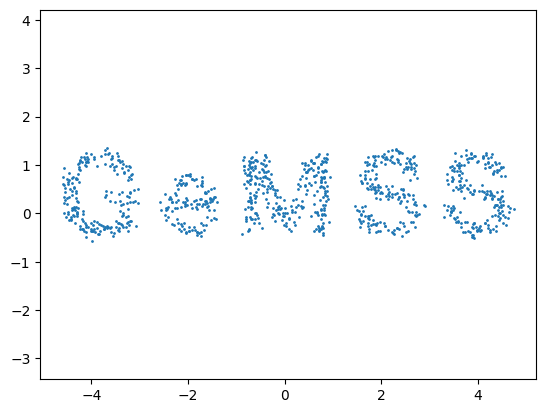

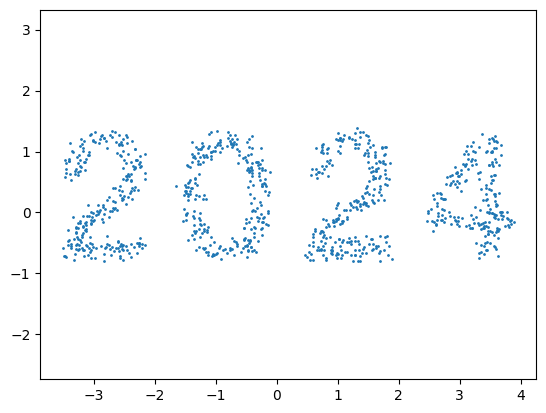

In [1]:
import numpy as np
import torch
from tqdm.auto import tqdm
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt


def sample_points_from_mask(mask, num_samples=1000, sigma=0.05):
    # Get the indices of the pixels that are part of the letters
    letter_indices = np.argwhere(mask)

    # Uniformly sample points from these indices
    sampled_indices = letter_indices[np.random.choice(len(letter_indices), num_samples)]
    x = sampled_indices.astype(np.float32)
    x[:, 0] = -(x[:, 0] - mask.shape[0]/2) / (mask.shape[0]/8 )
    x[:, 1] = (x[:, 1] - mask.shape[1]/2) / (mask.shape[0]/8)
    x = np.flip(x,1)
    x = torch.tensor(x.astype('float32')) 
    x = x + sigma * torch.randn_like(x)
    return x


# Load the mask
gemss_mask = Image.open(r'gemss.png')
gemss_mask = np.array(gemss_mask)
gemss_mask = (gemss_mask==255)[:,:,0]

# Load the mask
year_mask = Image.open(r'2024.png')
year_mask = np.array(year_mask)
year_mask = (year_mask==255)[:,:,0]


gemss_samples = sample_points_from_mask(gemss_mask, num_samples=1000).numpy()
year_samples = sample_points_from_mask(year_mask, num_samples=1000).numpy()

def plot_x(xt_):
    plt.scatter(xt_[:,0],xt_[:,1],s=1)
    plt.axis('equal')
    plt.show()
    
plot_x(gemss_samples)

plot_x(year_samples)

## Model architecture 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x): 
        return torch.sigmoid(x)*x


class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(MLP, self).__init__()

    self.num_layers = num_layers
    self.layers = nn.ModuleList()

    self.layers.append(nn.Linear(input_size, hidden_size))
    for i in range(self.num_layers-2):
        self.layers.append(nn.Linear(hidden_size, hidden_size))
    self.layers.append(nn.Linear(hidden_size, output_size))

    self.act = Swish()

  def forward(self, x, t):
    x = torch.cat([t, x],dim=1)
    for i in range(self.num_layers-1):
      x = self.act(self.layers[i](x))
    out = self.layers[-1](x)
    return out


## Model and Optimizer

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = MLP(input_size=3,hidden_size=512,output_size=2,num_layers=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training Loop

In [4]:
n_iters = 5000
batch_size = 4000

for iter in tqdm(range(n_iters)):
            
    optimizer.zero_grad()

    # sample t~U[0,1]
    t = torch.rand((batch_size,1)).to(device)
    
    # sample x0~p
    x0 = sample_points_from_mask(gemss_mask, num_samples=batch_size).to(device)
    
    # sample x1~q
    x1 = sample_points_from_mask(year_mask, num_samples=batch_size).to(device)
    
    # compute conditional flow 
    # xt = psi_t(x0|x1) = sigma_t*x0 + alpha_t*x1
    xt = (1-t)*x0 + t*x1

    # compute conditional velocity 
    # u_t(x|x1) = dsigma_t/dt*x0 + dalpha_t/dt*x1
    ut = x1-x0

    # forward
    vt = model(xt,t)

    # loss
    loss = (vt - ut).pow(2).mean()

    # optimize
    loss.backward()
    optimizer.step()



 58%|██████████████████████████████████████▋                            | 2883/5000 [00:35<00:25, 82.19it/s]


KeyboardInterrupt: 

## Sample

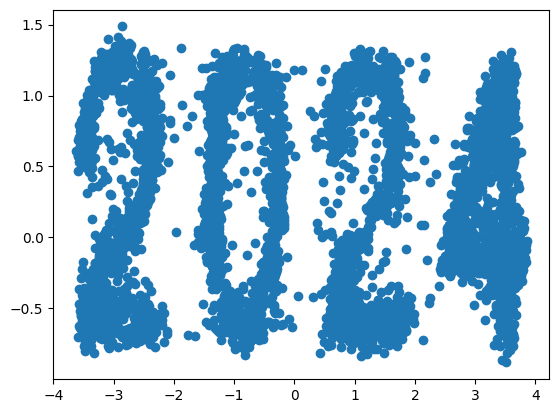

In [13]:
x0 = sample_points_from_mask(gemss_mask, num_samples=5000).to(device)
t = torch.zeros((5000,1)).to(device)

# number of discretization steps
N = 100
xt = x0

for i in range(N):
    xt = xt + model(xt,t)* (1/N)
    t  = t + 1/N
    
import matplotlib.pyplot as plt

plt.scatter(xt[:,0].cpu().detach().numpy(),xt[:,1].cpu().detach().numpy())




## Sample and animate

In [14]:
x0 = sample_points_from_mask(gemss_mask, num_samples=5000).to(device)
t = torch.zeros((5000,1)).to(device)
xt = x0

N = 100
traj = []
with torch.no_grad():
    for i in range(N):
        
        vt = model(xt,t)
        xt = xt + vt/N
        t = t + 1/N

        if (i+1) % 2 ==0:
            xt_ = xt.cpu().numpy()
            traj.append(xt_)


import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

fig, ax = plt.subplots()
def animate(i):
    ax.cla()
    ax.scatter(traj[i][:,0],traj[i][:,1],s=1)
    ax.set_xlim(-5,5)
    ax.set_ylim(-1,1.5)
    ax.axis('off')
    return fig
ani = animation.FuncAnimation(fig, animate, frames=50)
display(ani)